In [118]:
from typing import TypedDict, Annotated
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
import operator

In [119]:
load_dotenv()

True

In [120]:
model = ChatOpenAI(model="gpt-4o-mini")

In [121]:
class EvaluationSchema(BaseModel):
    feedback: str= Field(description="Detailed feedback for the easy")
    score: int= Field(description="Score out of 10", ge=0, le=10)

In [122]:
structured_model = model.with_structured_output(EvaluationSchema)

In [123]:
class UPSEState(TypedDict):
    eassy: str
    language_feedback: str
    analysis_feedback: str
    clarity_feedback: str
    overall_feedback: str
    indvidual_scores: Annotated[list[int], operator.add] 
    avg_score : float

In [124]:
def evaluate_language(state: UPSEState) -> UPSEState:
    prompt = f"Evalulate the language quality of the following easy and provide a feedback and assign a score out 10 \n {state['eassy']}"
    output = structured_model.invoke(prompt)

    return {'language_feedback' : output.feedback, 'indvidual_scores': [output.score]}

In [125]:
def evaluate_analysis(state: UPSEState) -> UPSEState:
    prompt = f"Evalulate the depth of analysis of the following easy and provide a feedback and assign a score out 10 \n {state['eassy']}"
    output = structured_model.invoke(prompt)

    return {'analysis_feedback' : output.feedback, 'indvidual_scores': [output.score]}

In [126]:
def evaluate_thought(state: UPSEState) -> UPSEState:
    prompt = f"Evalulate the clearity of thought  of the following easy and provide a feedback and assign a score out 10 \n {state['eassy']}"
    output = structured_model.invoke(prompt)

    return {'clarity_feedback' : output.feedback, 'indvidual_scores': [output.score]}

In [127]:
def final_evalution(state: UPSEState) -> UPSEState:
    prompt = f"Based on the following feedback Create a summarize feedback \n lnaguage feedback: {state['language_feedback']} \n depth of analysis feedback: {state['analysis_feedback']} \n clarity of though feedback {state['clarity_feedback']}"
    final_feedback = model.invoke(prompt).content

    avg = sum(state['indvidual_scores'])/len(state['indvidual_scores'])
    return {'overall_feedback': final_feedback, 'avg_score': avg}

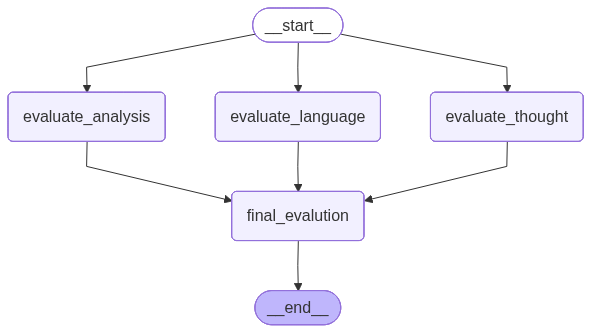

In [131]:
state = StateGraph(UPSEState)

state.add_node('evaluate_language', evaluate_language)
state.add_node('evaluate_analysis', evaluate_analysis)
state.add_node('evaluate_thought', evaluate_thought)
state.add_node('final_evalution', final_evalution)

state.add_edge(START,'evaluate_language')
state.add_edge(START,'evaluate_analysis')
state.add_edge(START,'evaluate_thought')

state.add_edge('evaluate_language','final_evalution')
state.add_edge('evaluate_analysis','final_evalution')
state.add_edge('evaluate_thought','final_evalution')
state.add_edge('final_evalution',END)


workflow = state.compile()
workflow

In [129]:
eassy = "Technology have evolved from being a mere tool of convenience to became the invisible architect shaping modern civilization. From the Industrial Revolution to the Digital Age, technological advancements was transforming economies, governance, social structures, and even human relationship. In the 21st century, technologies such as Artificial Inteligence, biotechnology, and renewable energy is not only influence progress but also redefining the very meaning of developement.However, while technology promise empowerment and prosperity, it also raise ethical, social, and enviromental concern. Many peoples is believing that technology are solving all the problems of humanity, but it have also created new challenges like unemployment and privacy issues. Society depend heavily on digital platforms which was affecting human interactions negatively.Therefore, understanding its role require a balanced and hollistic perspective. If technology will continue without proper regulation, it may creates more harm than benefits. Governments and citizens must taking responsibility to ensure that technology serve the mankind properly."

In [130]:
initial_state = {
    'eassy': eassy,
}
workflow.invoke(initial_state)

{'eassy': 'Technology have evolved from being a mere tool of convenience to became the invisible architect shaping modern civilization. From the Industrial Revolution to the Digital Age, technological advancements was transforming economies, governance, social structures, and even human relationship. In the 21st century, technologies such as Artificial Inteligence, biotechnology, and renewable energy is not only influence progress but also redefining the very meaning of developement.However, while technology promise empowerment and prosperity, it also raise ethical, social, and enviromental concern. Many peoples is believing that technology are solving all the problems of humanity, but it have also created new challenges like unemployment and privacy issues. Society depend heavily on digital platforms which was affecting human interactions negatively.Therefore, understanding its role require a balanced and hollistic perspective. If technology will continue without proper regulation, it